# ASL Alphabet Classifier Test


### The goal of this Sign2 variation is to experiment with using Mixup Regularization
(See "mixup: Beyond Empirical Risk Minimization" - Hongyi Zhang, Moustapha Cisse, Yann N. Dauphin, David Lopez-Pazj, 2018;  https://arxiv.org/abs/1710.09412) 

<br>

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will overfit, however it's a good test of the library.
<br>
<br>
### Data Wrangling info
The data has been reorganized to put sign images in labelled directories, making it easy to import and sort.
We use 2 main data directories and concatenate them together.  the 2nd dataset consists of personally captured images, created using the same notebook that does inference.  We capture every frame of a video and automatically place them in the chosen directory.  The notebook will create the main directory and the label-directory if they don't exist.

<img src="../docs/images/2021-01-13_00-57.png"><br>

<br>
<br>
<HR/>
<br>
<br>

In [1]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai


ARCH = resnet18  # resnet101
CHOSEN_SAMPLE_SIZE = 800 # use this to control per-category sample sizes # 1000
remove_from_sample = {
#     'A': 0.5,
#     'B': 0.6,
#     'C': 0.5,
#     'D': 0.4,
#     'E': 0.9,
# #     'L': 0.7,
#     'M': 0.8,
# #     'N': 0.9,
# #     'O': 0.75,
#     'Q': 0.75,
#     'R': 0.4,
#     'Y': 0.8 
    
    'A': 0.7,
    'C': 0.5,
#     'G': 0.7,

#     'H': 0.5
    'V': 0.7
}  # fractions of original samples to keep

EPOCHS = 4  # 4
FROZEN_EPOCHS = 4  # 1
BATCH_SIZE = 32  # 16
RESOLUTION = 400  # 300

data = 'frank'
rn_addon = '_data={data}'
time = datetime.today().strftime("%Y%m%d-%H%M")
RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION} {rn_addon}'
print(f"RUN_NAME = '{RUN_NAME}'")




import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

%env WANDB_WATCH=false

import wandb
from fastai.callback.wandb import *

wandb.init(project="asl-sign-language-recognition", mode='disabled')
wandb.run.name = RUN_NAME



RUN_NAME = '20210116-0200 - arch=resnet18 - samples=800 frozen=4 epochs=4 bs=32 res=400 _throwaway'
env: WANDB_WATCH=false


In [2]:
path = '../data/external/Training_Set'
# path2 = '../data/frank-ledlights-L'
path2 = None

<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER


<br>
<br>

### Check for Dataset Imbalance

In [4]:
from string import ascii_uppercase
import numpy as np
import operator
import matplotlib.pyplot as plt

image_files = {}
image_files_qty = {}

# loop through all the characters to build dictionaries of image files and quartity of each category
for c, i in zip(ascii_uppercase, np.arange(len(ascii_uppercase))):
    image_files[c] = get_image_files(path + f'/{c}')
    if path2 != None:
        image_files[c] += get_image_files(path2 + f'/{c}')

        
    l = len(image_files[c])
    image_files_qty[c] = l
    
# custom code since we don't use 'Z'
image_files.pop('J')
image_files_qty.pop('J')
image_files.pop('Z')
image_files_qty.pop('Z')

# Get the character with the largest and smallest number of entries
maxqc = max(image_files_qty, key=image_files_qty.get)
minqc = min(image_files_qty, key=image_files_qty.get)


print()
print(f'Character with the most images:   {maxqc},   with {image_files_qty[maxqc]} images')
print(f'Character with the least images:  {minqc},   with {image_files_qty[minqc]} images')
print(f'Average number of images:         {round(np.mean(list(image_files_qty.values())))}')




Character with the most images:   X,   with 5986 images
Character with the least images:  E,   with 2985 images
Average number of images:         4508


<br>
<br>

## Display the number of image files for each category

Text(0, 0.5, 'Sample Size')

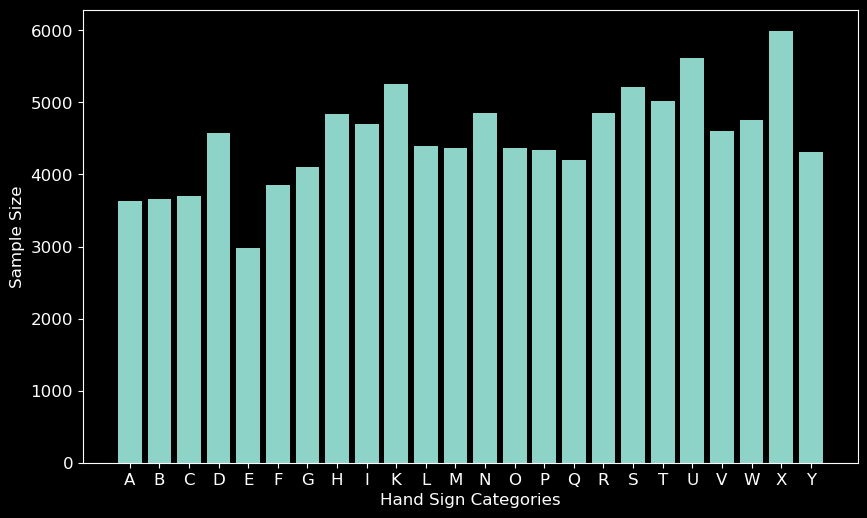

In [5]:
# plt.hist(image_files_qty.items)
plt.bar(image_files_qty.keys(), image_files_qty.values())
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')

<br>
<br>

### Balance the Dataset with Oversampling or Undersampling

In [6]:
import pandas as pd

maxq = image_files_qty[maxqc] # the quantity of the largest category
minq = image_files_qty[minqc] # the quantity of the smallest category

# all_image_files = pd.DataFrame(columns=[0])  # holds all the image files in one dataframe
train_image_files = {}
test_image_files = pd.DataFrame()

for char, q in iter(image_files_qty.items()):
    df = pd.DataFrame(data=list(image_files[char]), columns=[0])  # create a dataframe from each list
    

    # undersample or over sample as needed
    if len(df) >= CHOSEN_SAMPLE_SIZE:
        df = df.sample(CHOSEN_SAMPLE_SIZE, replace=False)  # undersample
    else:
        delta = CHOSEN_SAMPLE_SIZE - len(df)
        df = pd.concat([df, df.sample(delta, replace=(delta > len(df)))], ignore_index=True)  # oversample
        
    # siphon off the test set
    _tif = df[0].sample(100, replace=False)
    test_image_files[char] = _tif.reset_index(drop=True)
    
    # form  the training set
    train_image_files[char] = df[0].drop(_tif.index)
       
test_image_files = test_image_files.sample(frac=1)  # shuffle - training set is shuffled later

<br>
<br>

### Ensure the Dataset is Balanced

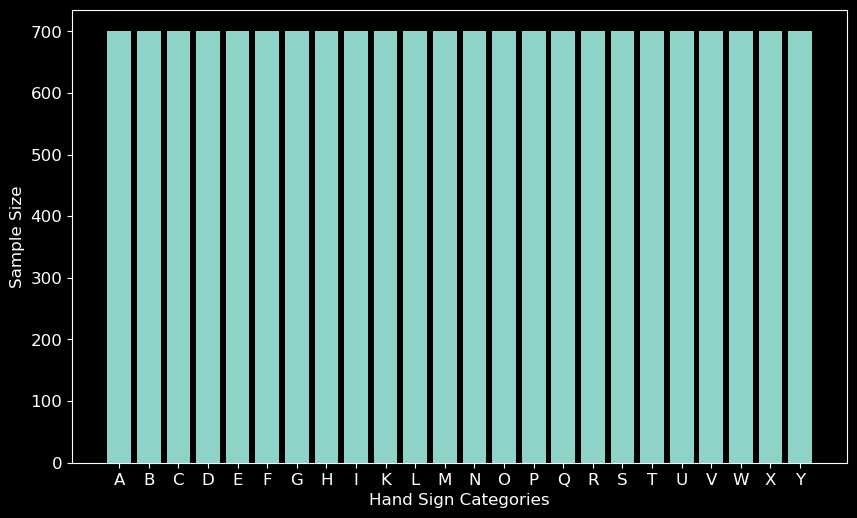

In [7]:
plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size');

<br>
<br>

### Check the  Test Set

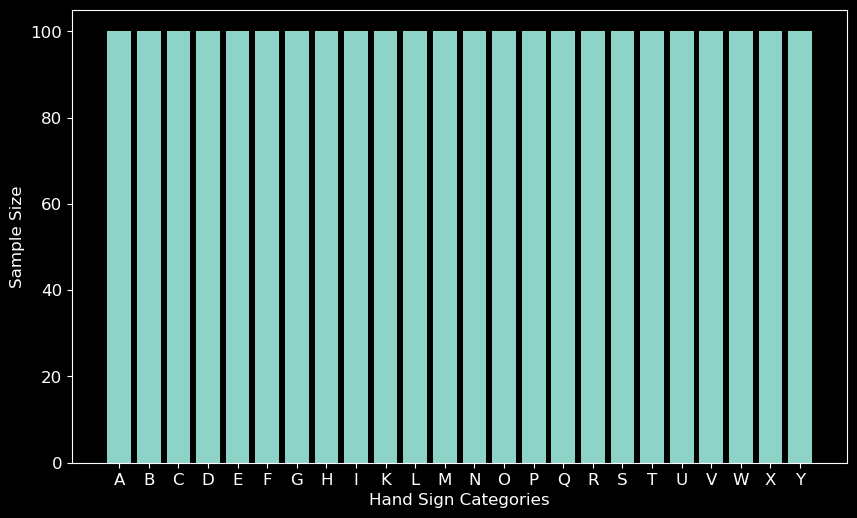

In [8]:
plt.bar(test_image_files.count().index, test_image_files.count())
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size');

<br>
<br>

### Deliberately Adjust the Sample Size of Certain Categories to Fine Tune the Model
Because the data is so easy to overfit and because we see certain categories fitting faster/stronger than others - causing the model to always select those categories... we try to balance that effect by decreasing the number of samples.

In [9]:
for key in remove_from_sample:
    train_image_files[key] = np.random.choice(train_image_files[key], \
                        int(remove_from_sample[key] * len(train_image_files[key])), replace=False)

<br>
<br>

### Check that the Training Dataset has been Appropriately Altered

Text(0, 0.5, 'Sample Size')

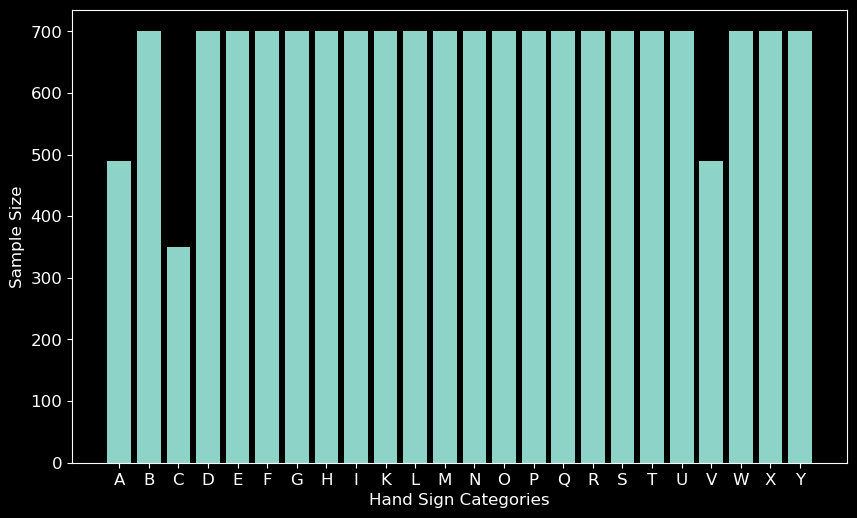

In [10]:
plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')

<br>
<hr/>
<br>
<br>
<br>

## Model Creation and Training

<br>

<br>

### Create the DataBlock, while Resizing and Augmenting

In [11]:
import random

# Needed to pass into the DataBlock    
def get_fnames(path): 
    retlist = []

    for arr in train_image_files.values():
        for f in arr:
            retlist.append(f)
        
    return random.sample(retlist, len(retlist))
        

    
    
    
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.4, seed=42),
    get_y=parent_label,
    item_tfms=Resize(RESOLUTION, method='bilinear') 
    ,    batch_tfms=aug_transforms(do_flip=True, batch=True, max_zoom=1.0, mult=3))


<br>
<br>

<br>

### Load the Data by Path

In [12]:
dls = signs.dataloaders(path, bs=BATCH_SIZE)
# wandb.log({'dataset':'../data/external/Training Set'})

<br>

### Verify the Training and Validation Batches

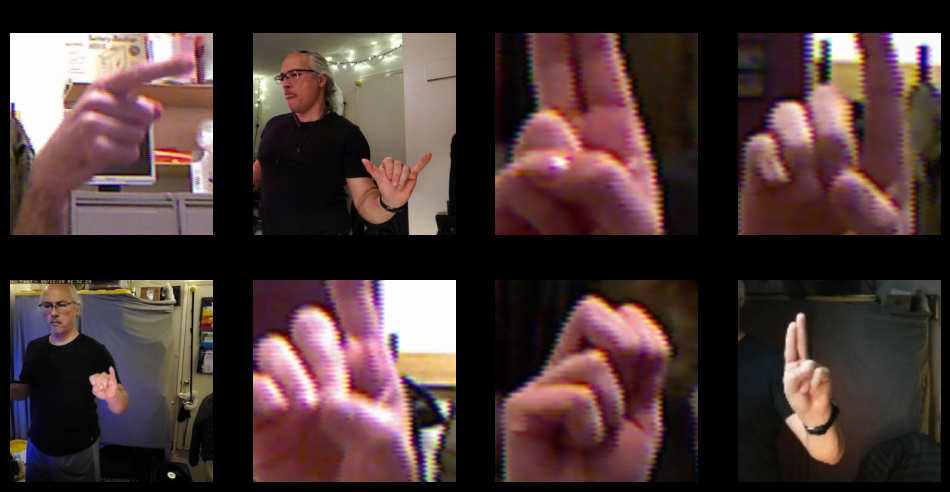

In [13]:
dls.train.show_batch(max_n=8, nrows=2)

<br>
<br>

### Define the model and fit

In [14]:
# wandb.log()
learn = cnn_learner(dls, arch=ARCH, metrics=[error_rate, accuracy])

<br>
<br>

### Look at the Loss Function, Optimization Function and Model Architecture

In [15]:
print('\nLoss Function: ', learn.loss_func)
print('\nOptimization Function: ', learn.opt_func)
# print('\n\n', learn.model)


Loss Function:  FlattenedLoss of CrossEntropyLoss()

Optimization Function:  <function Adam at 0x7f5a4d326af0>


<br>
<br>
<br>

## Create Callbacks

In [16]:
# Eary stopping callback
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0075, patience=2)

# Wandb Callback for logging
wandb_cb = WandbCallback(log='all', log_dataset=False)  #, log_dataset=True)

# Mixup callback for regularization
mixup_cb = MixUp(alpha=0.05)
# mixup_cb = None

<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

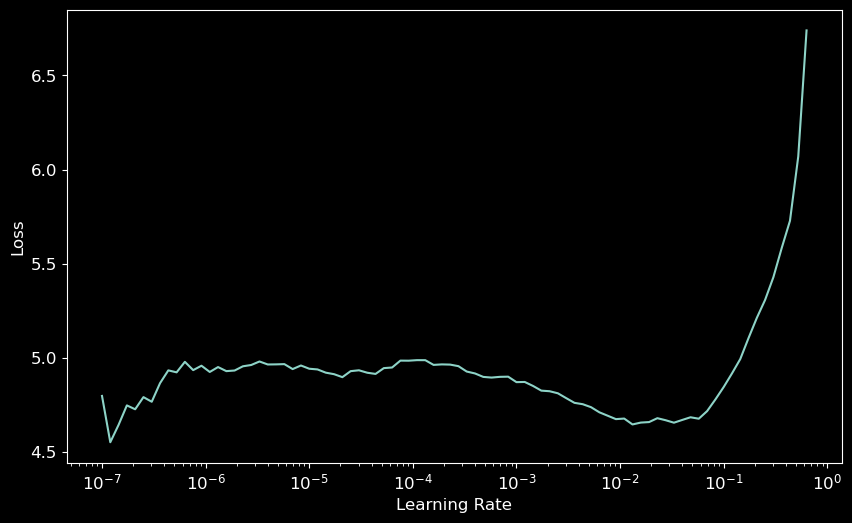

In [17]:
lr_min,lr_steep = learn.lr_find()

In [18]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.32e-03, steepest point: 6.31e-07


<br>
<br>

## Fit the last layers, unfreeze, fit the whole net, with a descriminant LR, all in one go.
Model architecture: 
Filename: ../models/{{RUN_NAME}}.pkl


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.275042,3.228626,0.876774,0.123226,01:37
1,3.404765,2.316307,0.691312,0.308688,01:39
2,2.939011,2.153461,0.632663,0.367337,01:37
3,2.418757,1.832236,0.555140,0.444860,01:37


Better model found at epoch 0 with valid_loss value: 3.228625535964966.


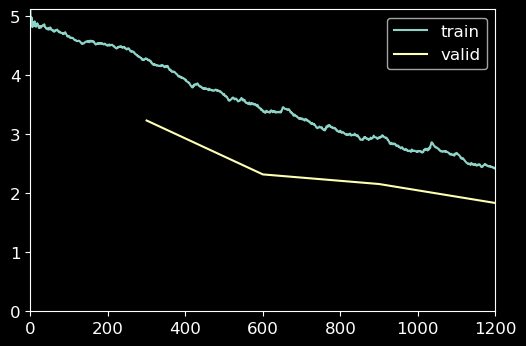

Better model found at epoch 1 with valid_loss value: 2.3163065910339355.
Better model found at epoch 2 with valid_loss value: 2.153461456298828.
Better model found at epoch 3 with valid_loss value: 1.8322361707687378.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.950867,1.042954,0.333021,0.666979,02:06
1,1.414206,0.596150,0.189206,0.810794,02:05
2,1.258758,0.499044,0.154578,0.845422,02:05
3,0.963743,0.404882,0.115739,0.884261,02:04


Better model found at epoch 0 with valid_loss value: 1.0429543256759644.


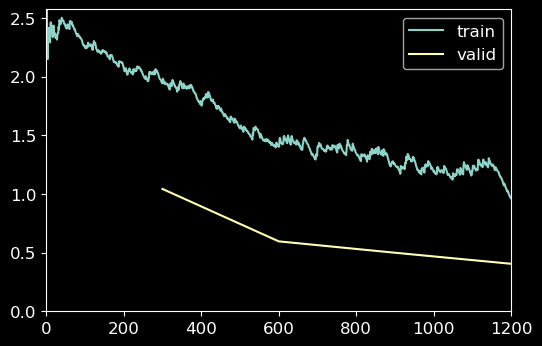

Better model found at epoch 1 with valid_loss value: 0.5961499214172363.
Better model found at epoch 2 with valid_loss value: 0.4990438222885132.
Better model found at epoch 3 with valid_loss value: 0.40488168597221375.


In [19]:
if mixup_cb == None:
    learn.fine_tune(EPOCHS, freeze_epochs=FROZEN_EPOCHS, base_lr=lr_min, 
                    cbs=[ShowGraphCallback(), wandb_cb, SaveModelCallback(), early_stop])
else:
    learn.fine_tune(EPOCHS, freeze_epochs=FROZEN_EPOCHS, base_lr=lr_min, 
                    cbs=[mixup_cb, ShowGraphCallback(), wandb_cb, SaveModelCallback(), early_stop])


In [20]:
# learn.fit(1, cbs=[mixup_cb, ShowGraphCallback(), early_stop])

<br>
<br>

## Persist the Model

In [21]:
learn.export(f'../models/{RUN_NAME}.pkl')
# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

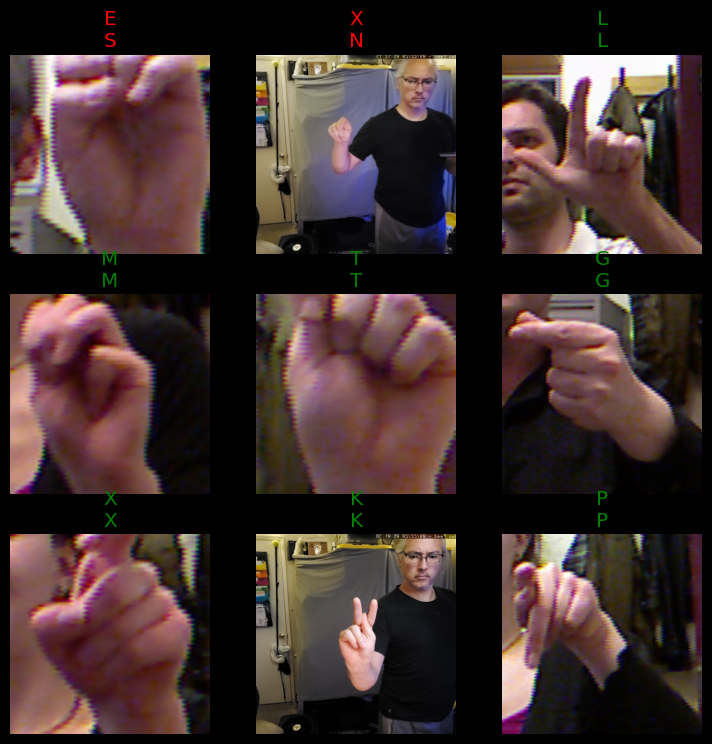

In [22]:
learn.show_results()

<br>
<hr>
<br>
<br>
<br>

## Validation Set (not the holdout) Analysis

<br>

### Plot Losses

In [23]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

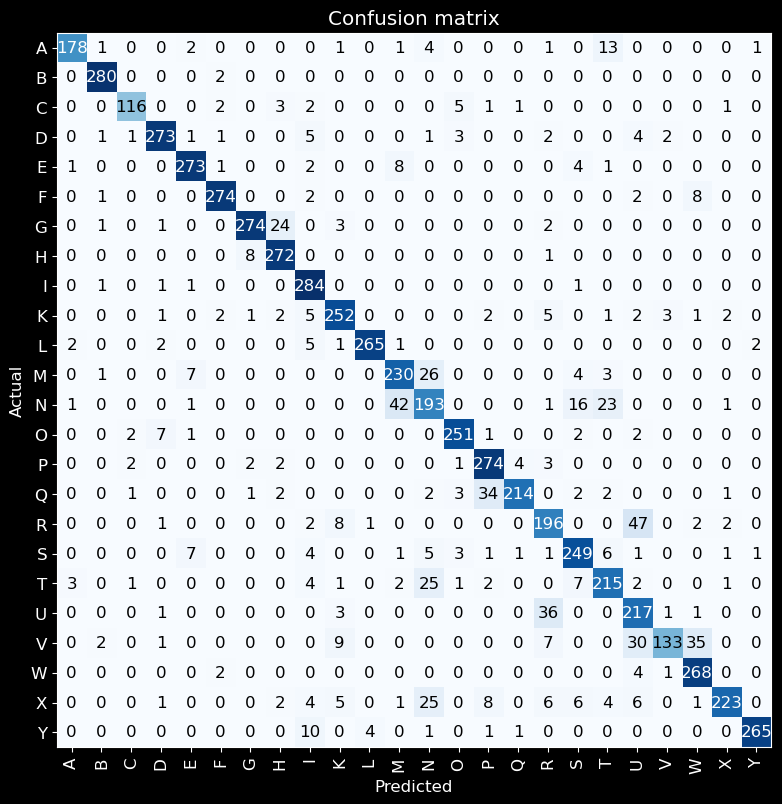

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [25]:
interp.most_confused()[:10]

[('R', 'U', 47),
 ('N', 'M', 42),
 ('U', 'R', 36),
 ('V', 'W', 35),
 ('Q', 'P', 34),
 ('V', 'U', 30),
 ('M', 'N', 26),
 ('T', 'N', 25),
 ('X', 'N', 25),
 ('G', 'H', 24)]

<br>
<br>

## Classification Report

In [26]:
interp.print_classification_report()

              precision    recall  f1-score   support

           A       0.96      0.88      0.92       202
           B       0.97      0.99      0.98       282
           C       0.94      0.89      0.91       131
           D       0.94      0.93      0.94       294
           E       0.93      0.94      0.94       290
           F       0.96      0.95      0.96       287
           G       0.96      0.90      0.93       305
           H       0.89      0.97      0.93       281
           I       0.86      0.99      0.92       288
           K       0.89      0.90      0.90       279
           L       0.98      0.95      0.97       278
           M       0.80      0.85      0.83       271
           N       0.68      0.69      0.69       278
           O       0.94      0.94      0.94       266
           P       0.85      0.95      0.90       288
           Q       0.97      0.82      0.89       262
           R       0.75      0.76      0.75       259
           S       0.86    

<br>

### Show the top 15 most error prone images

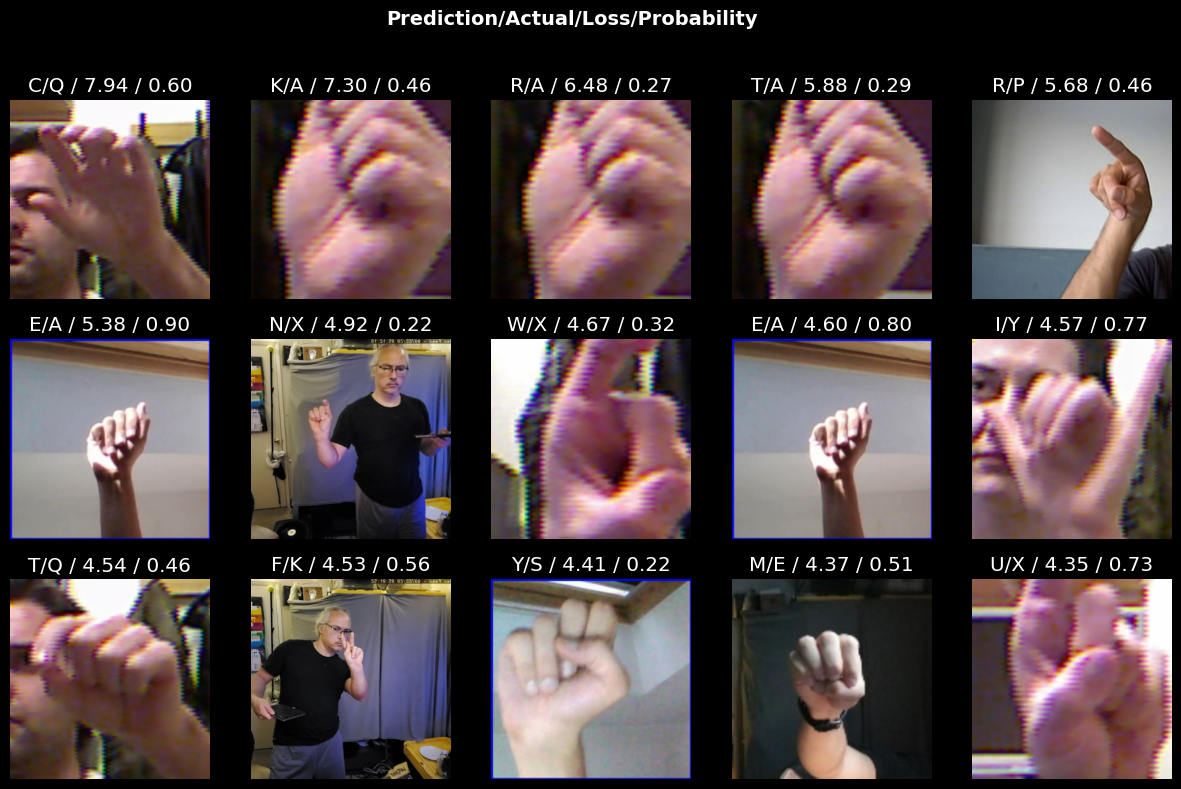

In [27]:
interp.plot_top_losses(15, nrows=3)

<br>

### ~~Clean the images that were hard to interpret and obviously bad~~

(I had to remove this section as it was using too much RAM and crashing the kernel)

### Show a Widget that allows us to mark poor exemplars for deletion

In [28]:
# import gc
# cleaner = None
# gc.collect()

# cleaner = ImageClassifierCleaner(learn)
# cleaner

### Show the Indexes of the images we want to delete

In [29]:
# cleaner.delete()

### Delete the files

In [30]:
# import os

# for idx in cleaner.delete():
#     print(f'removing: {str(cleaner.fns[idx])}')
#     os.remove(str(cleaner.fns[idx]))

<br>
<br>
<hr>
<br>
<br>




<br>
<br>

## Test Set Validation

<br>

In [31]:
test_learn = learn

import gc
cleaner = None
# learn = None
gc.collect()

62564

In [32]:
# learn = load_learner(f'../models/20210115-0815 - arch=resnet50 - samples=4000 frozen=1 epochs=1 bs=30 res=300 _throwaway.pkl', cpu=False)
# learn=load_learner(f'../models/20210114-1202 - arch=resnet101 - samples=4000 frozen=1 epochs=2 bs=16 res=300 _throwaway.pkl', cpu=False)
# test_learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)

In [33]:
def get_test_fnames(path):
    return list(test_image_files.values.flatten())

In [34]:
path

'../data/external/Training_Set'

In [35]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=Resize(RESOLUTION, method='bilinear')) #,



dls = test_db.dataloaders(path, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

<br>
<br>

####  Get the Inferrences on the Test Set

In [36]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [37]:
preds[-2]

tensor([0.1333, 0.0212, 0.0285, 0.0129, 0.0124, 0.0019, 0.0847, 0.0122, 0.0062, 0.0073, 0.0044, 0.0154, 0.0573, 0.0146, 0.0220, 0.0183, 0.0423, 0.0355, 0.1321, 0.0532, 0.0220, 0.0016, 0.2584, 0.0022])

In [38]:
targs

TensorCategory([ 0,  1,  2,  ..., 21, 22, 23])

In [39]:
decoded

tensor([ 0,  1, 13,  ..., 21, 22, 15])

In [40]:
losses[0]

TensorBase(0.0972)

In [41]:
get_test_fnames('')[-5:]

[Path('../data/external/Training_Set/U/oldwebcam-208.jpg'),
 Path('../data/external/Training_Set/V/1824.jpg'),
 Path('../data/external/Training_Set/W/color_22_0279 (5).png'),
 Path('../data/external/Training_Set/X/color_23_0379 (2).png'),
 Path('../data/external/Training_Set/Y/color_24_0480 (3).png')]

In [42]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

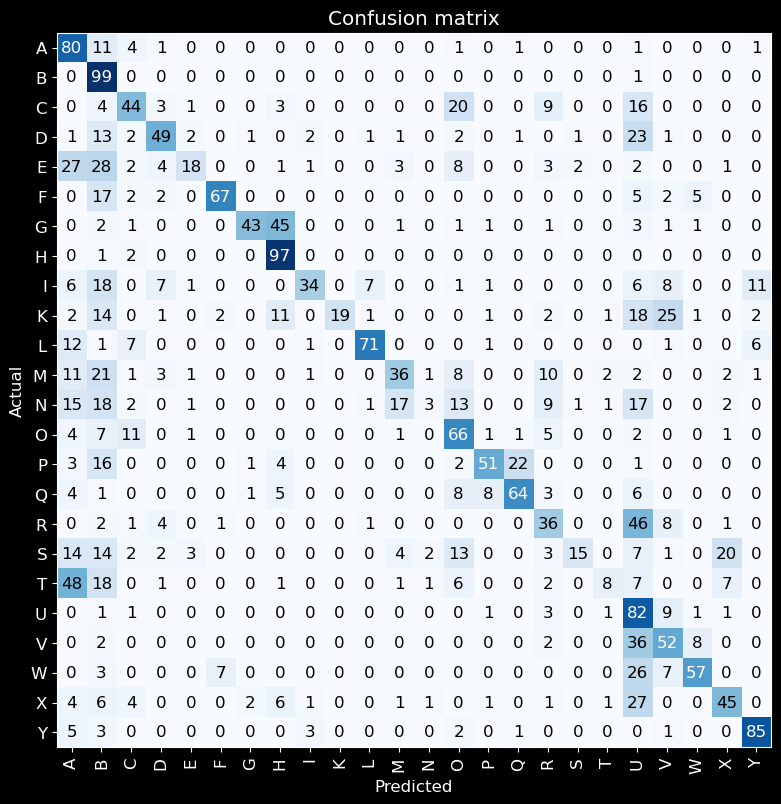

In [43]:
# interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [44]:
interp.most_confused()[:10]

[('T', 'A', 48),
 ('R', 'U', 46),
 ('G', 'H', 45),
 ('V', 'U', 36),
 ('E', 'B', 28),
 ('E', 'A', 27),
 ('X', 'U', 27),
 ('W', 'U', 26),
 ('K', 'V', 25),
 ('D', 'U', 23)]

<br>
<br>

## Classification Report

In [45]:
interp.print_classification_report()

              precision    recall  f1-score   support

           A       0.34      0.80      0.48       100
           B       0.31      0.99      0.47       100
           C       0.51      0.44      0.47       100
           D       0.64      0.49      0.55       100
           E       0.64      0.18      0.28       100
           F       0.87      0.67      0.76       100
           G       0.90      0.43      0.58       100
           H       0.56      0.97      0.71       100
           I       0.79      0.34      0.48       100
           K       1.00      0.19      0.32       100
           L       0.87      0.71      0.78       100
           M       0.55      0.36      0.44       100
           N       0.38      0.03      0.06       100
           O       0.44      0.66      0.53       100
           P       0.77      0.51      0.61       100
           Q       0.71      0.64      0.67       100
           R       0.40      0.36      0.38       100
           S       0.79    

<br>
<br>
<br>

## Clean up

<br>

In [46]:
wandb.join()

In [47]:
wandb.finish()

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.
* Added an Early Stop.  Starting with 0.01 delta.  
* Now moving to 0.1 delta
* Integrated wandb to keep track of experiments.
* added section to balance the dataset through oversampling.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    

In [48]:
# learn.unfreeze()

In [49]:
# learn.fine_tune(epochs=2, freeze_epochs=1, base_lr=high)
#                 cbs=[mixup_cb, ShowGraphCallback(), SaveModelCallback(), early_stop])

In [50]:
# low, high = learn.lr_find()

In [51]:
# low

In [52]:
# high

In [54]:
import os
import shutil
!sleep 20
shutil.copyfile('Sign2 - Implementing Mixup.ipynb', f'.Archive/{date} - Sign2 - Implementing Mixup.ipynb')

NameError: name 'date' is not defined